In [466]:
import os, psutil
import importlib

import einops
import numpy as np
import ssm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [467]:
np.set_printoptions(precision=3)
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [468]:
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available
print(f"The available RAM memory is {available_memory / (1024**3):.2f} GB out of {total_memory / (1024**3):.2f} GB")

The available RAM memory is 59.98 GB out of 125.68 GB


In [469]:
import os, psutil, sys
import importlib

import einops
import numpy as np
import ssm
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

from pathlib import Path
# parent_directory = Path(__file__).resolve().parent
parent_directory = Path(os.getcwd()).resolve().parent
sys.path.append(str(parent_directory))
sys.path.append(str(parent_directory) + '/models/')

# Generate data

In [1144]:
import ssm

num_states = 1
obs_dim = 2
time_bins = 10000

true_hmm = ssm.HMM(
    num_states, obs_dim, 
    observations="autoregressive",
    # observations="gaussian",
    transitions="inputdriven"
)

true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

In [1145]:
# true_hmm.observations._As, true_hmm.observations.bs

In [1146]:
# vars(true_hmm.observations)

In [1147]:
def convert_observations(obs, device, seed=0, cov_zero=True):
    torch.manual_seed(seed)
    x = torch.tensor(obs, dtype=torch.float32).to(device)
    # x_mean = einops.rearrange(x, 't f -> 1 f t')
    x_mean = einops.repeat(x, 't f -> 1 f t')
    x_cov = torch.randn((1, x_mean.shape[-2], x_mean.shape[-2], x_mean.shape[-1]), dtype=torch.float32).to(device)
    x_cov = torch.einsum('bcCt, bsCt -> bcst', x_cov, x_cov)
    if cov_zero:
        x_cov[:] = 0
    return x_mean, x_cov

# Whitening of the data

In [1148]:
import ar
importlib.reload(ar)

config_ar = ar.ARConfig(
    n_states=num_states,
    n_features=obs_dim,
    ar_order=1,
    covariance_type='full',
)
device = 'cpu'

In [1149]:
ar_model = ar.Autoregression(config_ar).to(device)

### set whitening_filters to the AR and mu coefs

In [1150]:
x_mean, x_cov = convert_observations(obs, device, seed=0)

In [1151]:
ar_model.An[:,1] = torch.tensor(true_hmm.observations._As[0], dtype=torch.float32, device=device)
ar_model.An[:,-1] = torch.diag(torch.tensor(true_hmm.observations.bs[0], dtype=torch.float32, device=device))
ar_model._update_filters()

In [1152]:
%%time
y = ar_model.whitening_filters[0](ar_model.pad(x_mean)).detach().cpu().numpy()

CPU times: user 1.57 ms, sys: 0 ns, total: 1.57 ms
Wall time: 964 µs


In [1153]:

print(np.mean(y, axis=-1))

[[ 0.001 -0.009]]


In [1154]:

gamma = torch.ones((config_ar.n_features, time_bins), device=x_mean.device) / config_ar.n_states

In [1155]:
gamma.shape

torch.Size([2, 10000])

In [1156]:
x_mean.shape, x_cov.shape 

(torch.Size([1, 2, 10000]), torch.Size([1, 2, 2, 10000]))

In [1157]:
x_cov

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [1159]:
# %%time
# ar_model._estimate_autoregression(x_mean, x_cov, gamma)

In [1160]:
# %%time
# ar_model._estimate_covariance(x_mean, x_cov, gamma)

In [1161]:
# %%time
# ar._estimate_covariance_slow(x_mean, x_cov, gamma)

In [1164]:
ar_model.fit(x_mean, x_cov)

In [1165]:
ar_model.reset()

In [1166]:
ar_model.fit(x_mean, x_cov)

In [1167]:
ar_model.Sigma

tensor([[[4.8922, 2.7979],
         [2.7979, 2.2025]]])

In [1168]:
%%time
log_prob_ar = ar_model.emission_log_prob(x_mean)

CPU times: user 2.37 ms, sys: 0 ns, total: 2.37 ms
Wall time: 1.43 ms


In [1175]:
%%time
log_prob_ar = ar_model.emission_log_prob_pytorch(x_mean)

EinopsError:  Error while processing rearrange-reduction pattern "k c t -> k t c".
 Input tensor shape: torch.Size([1, 1, 2, 10000]). Additional info: {}.
 Expected 3 dimensions, got 4

In [1173]:
log_prob_ar.shape

torch.Size([1, 1, 10000])

In [1174]:
log_prob_ar.shape

torch.Size([1, 1, 10000])

# HMM

In [1133]:
import ar
importlib.reload(ar)

import hmm
importlib.reload(hmm)

<module 'hmm' from '/home/user/common/amvosk/Projects/Speech Mapping Advanced/VAE-AR-HMM/models/hmm.py'>

In [1134]:
class ARHMM(nn.Module):
    def __init__(
        self,
        config_ar,
        config_hmm,
        random_seed,
    ):
        super(self.__class__,self).__init__()
        self.config_hmm = config_hmm
        self.config_ar = config_ar

        self.hmm = hmm.HMM(self.config_hmm, random_seed)
        self.ar = ar.Autoregression(self.config_ar)
        
    def forward(self, x):
        return None
        
    def fit(self, x_mean, x_cov, n_iterations=50, mask=None):
        log_probs = []
        for iteration in tqdm(range(n_iterations)):
            # print(x_mean.shape, x_cov.shape)
            emissions = self.ar.emission_log_prob(x_mean)
            # emissions = einops.rearrange(emissions, 'f t -> 1 f t')
            # print(emissions.shape)
            log_prob, gamma = self.hmm.fit(emissions)
            # print(x_mean.shape, x_cov.shape)
            
            # x_mean = einops.rearrange(x_mean, '1 f t -> f t')
            # x_cov = einops.rearrange(x_cov, '1 f F t -> f F t')
            self.ar.fit(x_mean, x_cov, gamma)
            # x_mean = einops.rearrange(x_mean, 'f t -> 1 f t')
            # x_cov = einops.rearrange(x_cov, 'f F t -> 1 f F t')
            
            log_probs.append(log_prob.detach().cpu().numpy().item())
        return log_probs
            
    def predict(self, x_mean):
        emissions = self.ar.emission_log_prob(x_mean)
        path = self.hmm.predict(emissions)
        return path

# Generate some GaussHMM data

In [1135]:
import ssm

num_states = 3
obs_dim = 2
time_bins = 1000
observations = "gaussian"
# observations = "autoregressive"

true_hmm = ssm.HMM(
    num_states, obs_dim, 
    observations=observations,
    transitions="inputdriven"
)

true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

In [1136]:
config_ar = ar.ARConfig(
    n_states=num_states,
    n_features=obs_dim,
    ar_order= 0 if observations == "gaussian" else 1,
    covariance_type='full'
)

# device = 'cuda'
device = 'cpu'

config_hmm = hmm.HMMConfig(
    n_states=num_states,
    init_state_type='uniform',
    transition_matrix_type='random',
    transition_type='full',
    diagonal_coef=0,
    first_coef=0,
    ergodicity_coef=0,
    temperature=1,
)

random_seed = 42

## From library

In [1137]:
N_iters = 50

## testing the constrained transitions class
hmm_ssm = ssm.HMM(num_states, obs_dim, observations=observations)

hmm_lls = hmm_ssm.fit(obs, method="em", num_iters=N_iters)#, init_method="kmeans")

LP: -2465.4: 100%|██████████| 50/50 [00:00<00:00, 296.81it/s]


## Mine

In [1138]:
x_mean, x_cov = convert_observations(obs, device, seed=0, cov_zero=True)

In [1139]:
arhmm = ARHMM(config_ar, config_hmm, random_seed).to(device)
N_iters = 50

log_prob = arhmm.fit(x_mean, x_cov, n_iterations=N_iters)
log_prob[-1]

100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


-2465.457763671875

In [964]:
# plt.plot(log_prob)

In [965]:
mu, sigma = arhmm.ar._get_mean().cpu().numpy(), arhmm.ar._get_cov().cpu().numpy()

In [966]:
mu_true = true_hmm.observations.mus
mu_learned = hmm_ssm.observations.mus
mu_mine = arhmm.ar._get_mean().cpu().numpy()

In [967]:
sigma_true = np.einsum('kcC, ksC -> kcs', true_hmm.observations._sqrt_Sigmas, true_hmm.observations._sqrt_Sigmas)
sigma_learned = np.einsum('kcC, ksC -> kcs', hmm_ssm.observations._sqrt_Sigmas, hmm_ssm.observations._sqrt_Sigmas)
sigma_mine = arhmm.ar._get_cov().cpu().numpy()

In [968]:
def plot_ar_matrix(matrices):
    n_matrices = matrices.shape[0]
    fig, ax = plt.subplots(1, n_matrices, figsize=(15, 3))

    for i in range(n_matrices):
        matrix = matrices[i]
        vmax = np.max(np.abs(matrix))
        vmin = -vmax
        cmap = plt.get_cmap("coolwarm")
        # Plot the covariance matrix using imshow
        im = ax[i].imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)

        cax = fig.add_axes([ax[i].get_position().x1 + 0.01, ax[i].get_position().y0, 0.02, ax[i].get_position().height])
        cbar = fig.colorbar(im, cax=cax)
        
        
        num_variables = matrix.shape[0]
        tick_positions = np.arange(num_variables)
        ax[i].set_xticks(tick_positions)
        ax[i].set_yticks(tick_positions)
        ax[i].set_xticklabels(tick_positions)
        ax[i].set_yticklabels(tick_positions)

        ax[i].set_title(f'ar state {i}')
    plt.show()

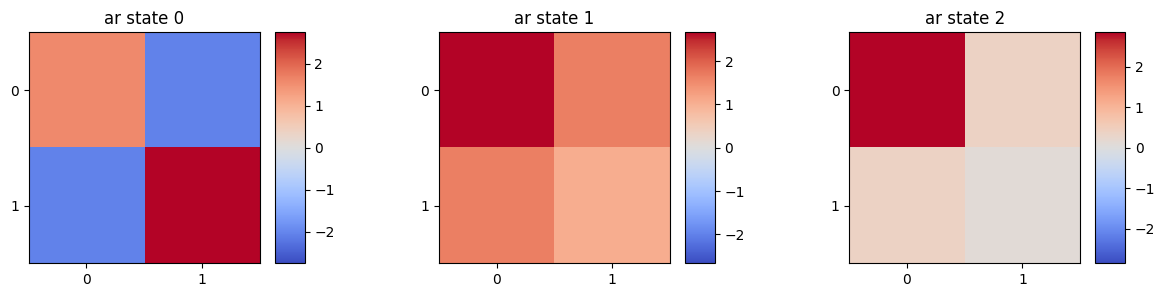

In [969]:
plot_ar_matrix(sigma_true)

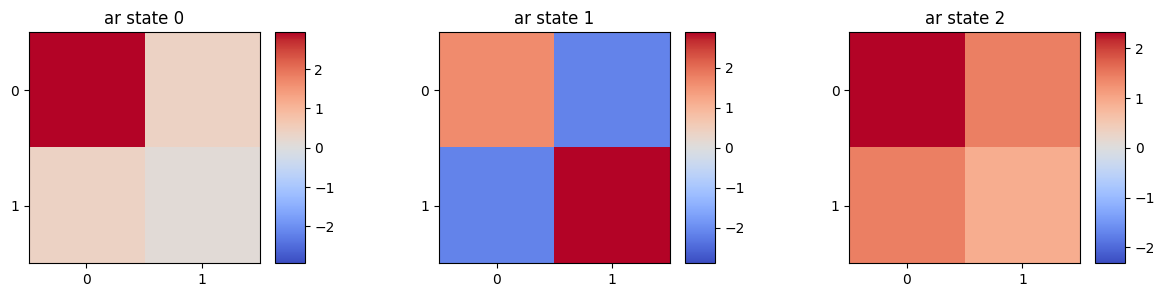

In [970]:
plot_ar_matrix(sigma_learned)

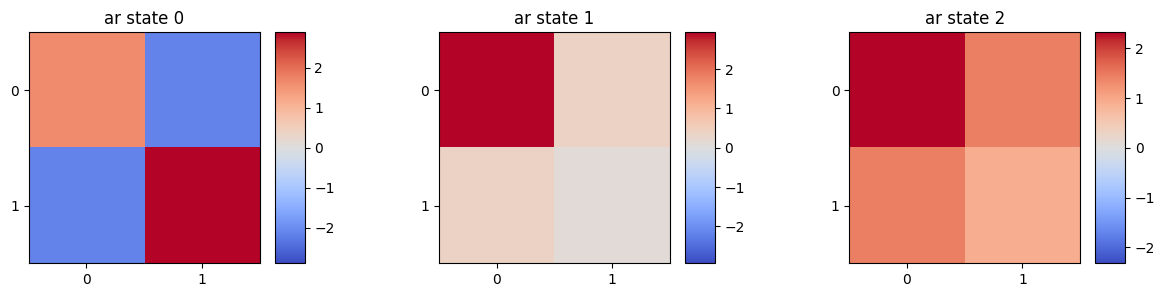

In [971]:
plot_ar_matrix(sigma_mine)

In [979]:
x_mean, x_cov = convert_observations(obs, device, seed=0, cov_zero=False)

In [980]:
%%time
x_samples = arhmm.ar.sample(x_mean, x_cov, n_samples=100, random_seed=0)

CPU times: user 39.7 ms, sys: 0 ns, total: 39.7 ms
Wall time: 9.63 ms


In [981]:
x_samples.shape

torch.Size([100, 2, 1000])

In [982]:
%%time
prob = arhmm.ar.emission_log_prob(x_samples)

CPU times: user 57.1 ms, sys: 0 ns, total: 57.1 ms
Wall time: 9.83 ms


In [975]:
emission_log_prob_pytorch

NameError: name 'emission_log_prob_pytorch' is not defined

# Generate some AR-HMM data

In [ ]:
import ar
importlib.reload(ar)

import hmm
importlib.reload(hmm)

In [ ]:
import ssm

num_states = 3
obs_dim = 2
time_bins = 1000
observations = "autoregressive"

true_hmm = ssm.HMM(
    num_states, obs_dim, 
    observations=observations,
    transitions="inputdriven"
)

true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

In [ ]:
config_ar = ar.ARConfig(
    n_states=num_states,
    n_features=obs_dim,
    ar_order= 0 if observations == "gaussian" else 1,
    covariance_type='full' # 'full', 'diagonal', 'spherical', 'common', 'identity'
)

# device = 'cuda'
device = 'cpu'

config_hmm = hmm.HMMConfig(
    n_states=num_states,
    init_state_type='uniform',
    transition_matrix_type='random',
    transition_type='full',
    diagonal_coef=0,
    first_coef=0,
    ergodicity_coef=0,
    temperature=1,
)

random_seed = 42

In [ ]:
N_iters = 50

## testing the constrained transitions class
hmm_ssm = ssm.HMM(num_states, obs_dim, observations=observations)

hmm_lls = hmm_ssm.fit(obs, method="em", num_iters=N_iters)#, init_method="kmeans")

In [ ]:
x_mean, x_cov = convert_observations(obs, device, seed=0)

In [ ]:
x_mean.shape

In [ ]:
arhmm = ARHMM(config_ar, config_hmm, random_seed).to(device)
N_iters = 50

log_prob = arhmm.fit(x_mean, x_cov, n_iterations=N_iters)
log_prob[-1]

In [ ]:
%%time
emissions = arhmm.ar.emission_log_prob(x_mean)

In [976]:
%%time
log_prob, gamma = arhmm.hmm.fit(emissions)

CPU times: user 79.3 ms, sys: 0 ns, total: 79.3 ms
Wall time: 76.1 ms


In [977]:
%%time
arhmm.ar.fit(x_mean, x_cov, gamma)

CPU times: user 5.05 ms, sys: 0 ns, total: 5.05 ms
Wall time: 3.77 ms


In [978]:
arhmm.ar.Sigma

tensor([[[3.2824, 0.6841],
         [0.6841, 2.3988]],

        [[2.9154, 0.0693],
         [0.0693, 2.4317]],

        [[3.0325, 0.2069],
         [0.2069, 2.2381]]])

# VAE

In [7]:
import os, psutil, sys
import importlib

import einops
import numpy as np
import ssm
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

from pathlib import Path
# parent_directory = Path(__file__).resolve().parent
parent_directory = Path(os.getcwd()).resolve().parent
sys.path.append(str(parent_directory) + '/models/')

In [84]:
import vae
importlib.reload(vae)

<module 'vae' from '/home/user/common/amvosk/Projects/Speech Mapping Advanced/VAE-AR-HMM/models/vae.py'>

In [103]:
config_vae = vae.VAEConfig(
    n_channels=15,
    n_features=3,
    log_transform=False,
    fs=1024,
    fsamp=16,
    ma_order_encoder=1,
    ma_order_decoder=1,
    use_ma_bias=True,
    ma_bias_common=True,
    use_cov_scaler=False,
)

random_seed = 42

In [104]:
fs = 1024
dataset = np.load('../datasets/spmap_80-100hz.npz')
stimulus = dataset['stimulus']
ecogf = dataset['ecogf'][:,stimulus[1]:]
stimulus = stimulus[1:] - stimulus[1]
sound = dataset['sound'][stimulus[1]*4:]
ecogf = ecogf[:,:(ecogf.shape[1] // fs) * fs]
bad_channels = dataset['bad_channels']

In [105]:
vae_model = vae.VAE(config_vae, random_seed)

In [106]:
y = torch.tensor(ecogf, dtype=torch.float32)

In [107]:
results = vae_model(y)

In [108]:
for k, v in results.items():
    if v is not None:
        print(k, v.shape)

y_minibatch torch.Size([15, 222208])
s torch.Size([3, 222208])
s_abs torch.Size([3, 222208])
s_sign torch.Size([3, 222208])
a_mean torch.Size([3, 3472])
a_cov torch.Size([3, 3, 3472])
x_mean torch.Size([3, 3472])
x_cov torch.Size([3, 3, 3472])
s_abs_tilde torch.Size([3, 222208])
s_tilde torch.Size([3, 222208])
y_mean_tilde torch.Size([15, 222208])


In [53]:
for k, v in results.items():
    if v is not None:
        print(k, v.shape)

y_minibatch torch.Size([15, 222208])
s torch.Size([3, 222208])
s_abs torch.Size([3, 222208])
s_sign torch.Size([3, 222208])
a_mean torch.Size([3, 3472])
a_cov torch.Size([3, 3, 3472])
x_mean torch.Size([3, 3472])
x_cov torch.Size([3, 3, 3472])
s_abs_tilde torch.Size([3, 222208])
s_tilde torch.Size([3, 222208])
y_mean_tilde torch.Size([15, 222208])
